In [1]:
import pandas as pd
import numpy as np
import glob
import datetime as dt
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle

In [2]:
def load_scws(rid):
    
    df1 = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/points/"+rid+"_scw_envs_df.csv")
    df1["cluster_new"] = df1.cluster.map({1:2,2:1,0:0})
    df1 = df1.set_index(pd.DatetimeIndex(df1.dt_utc))
    df1["month"] = df1.index.month
    df1["hour"] = df1.index.hour
    df1["aspect_ratio"] = df1.major_axis_length / df1.minor_axis_length
    return df1

In [3]:
melb = load_scws("2")
bris = load_scws("66")
namoi = load_scws("69")
perth = load_scws("70")
syd = load_scws("71")


209 65 124


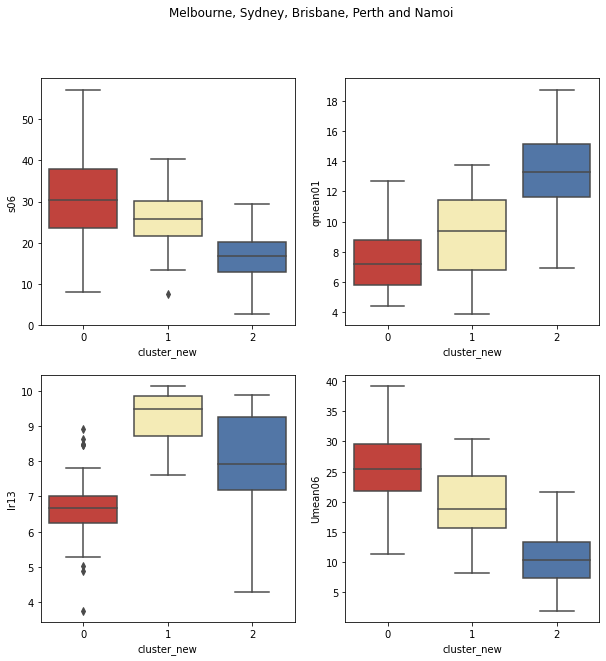

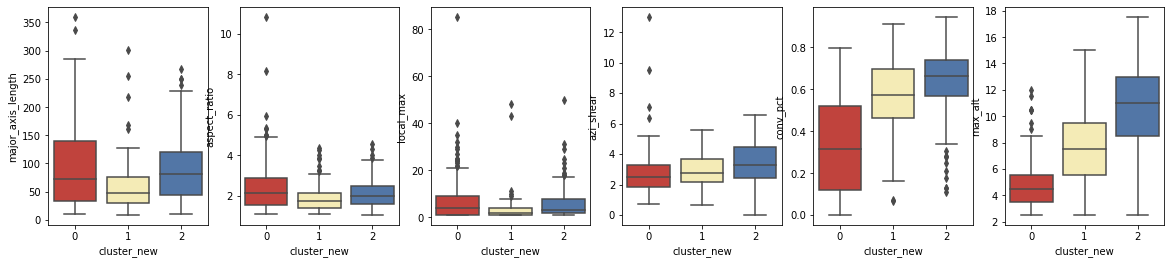

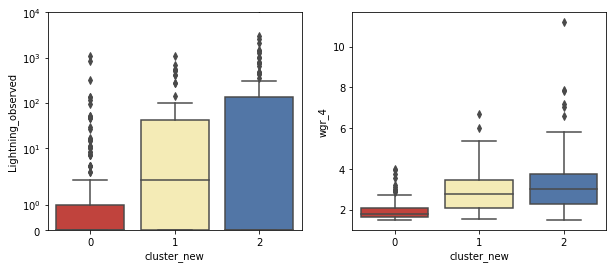

In [5]:
def plot_boxplot_stats(data, title):
    
    print( (data.cluster_new==0).sum(), (data.cluster_new==1).sum(), (data.cluster_new==2).sum())
    
    p = [plt.get_cmap("RdYlBu")(i) for i in [0.1,0.46,0.9]]
    
    plt.figure(figsize=[10,10])
    ax=plt.subplot(2,2,1)
    sns.boxplot(data=data, x="cluster_new", y="s06", palette=p)
    ax=plt.subplot(2,2,2)
    sns.boxplot(data=data, x="cluster_new", y="qmean01", palette=p)
    ax=plt.subplot(2,2,3)
    sns.boxplot(data=melb, x="cluster_new", y="lr13", palette=p)
    ax=plt.subplot(2,2,4)
    sns.boxplot(data=data, x="cluster_new", y="Umean06", palette=p)
    plt.suptitle(title)
    
    plt.figure(figsize=[20,4])
    data["aspect_ratio"] = data["major_axis_length"] / data["minor_axis_length"]
    plt.subplot(1,6,1)
    sns.boxplot(data=data, x="cluster_new", y="major_axis_length", palette=p)
    plt.subplot(1,6,2)
    sns.boxplot(data=data, x="cluster_new", y="aspect_ratio", palette=p)
    plt.subplot(1,6,3)
    sns.boxplot(data=data, x="cluster_new", y="local_max", palette=p)
    plt.subplot(1,6,4)
    sns.boxplot(data=data, x="cluster_new", y="azi_shear", palette=p)
    plt.subplot(1,6,5)
    sns.boxplot(data=data, x="cluster_new", y="conv_pct", palette=p)
    plt.subplot(1,6,6)
    sns.boxplot(data=data, x="cluster_new", y="max_alt", palette=p)

    plt.figure(figsize=[10,4])
    plt.subplot(1,2,1)
    sns.boxplot(data=data, x="cluster_new", y="Lightning_observed", palette=p)
    plt.yscale("symlog")
    plt.ylim([0,10000])
    
    plt.subplot(1,2,2)
    sns.boxplot(data=data, x="cluster_new", y="wgr_4", palette=p)
                       
plot_boxplot_stats(pd.concat([melb, syd, bris, perth, namoi], axis=0), "Melbourne, Sydney, Brisbane, Perth and Namoi")
plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/scws_cluster_boxplot.jpeg",dpi=1000,bbox_inches="tight")

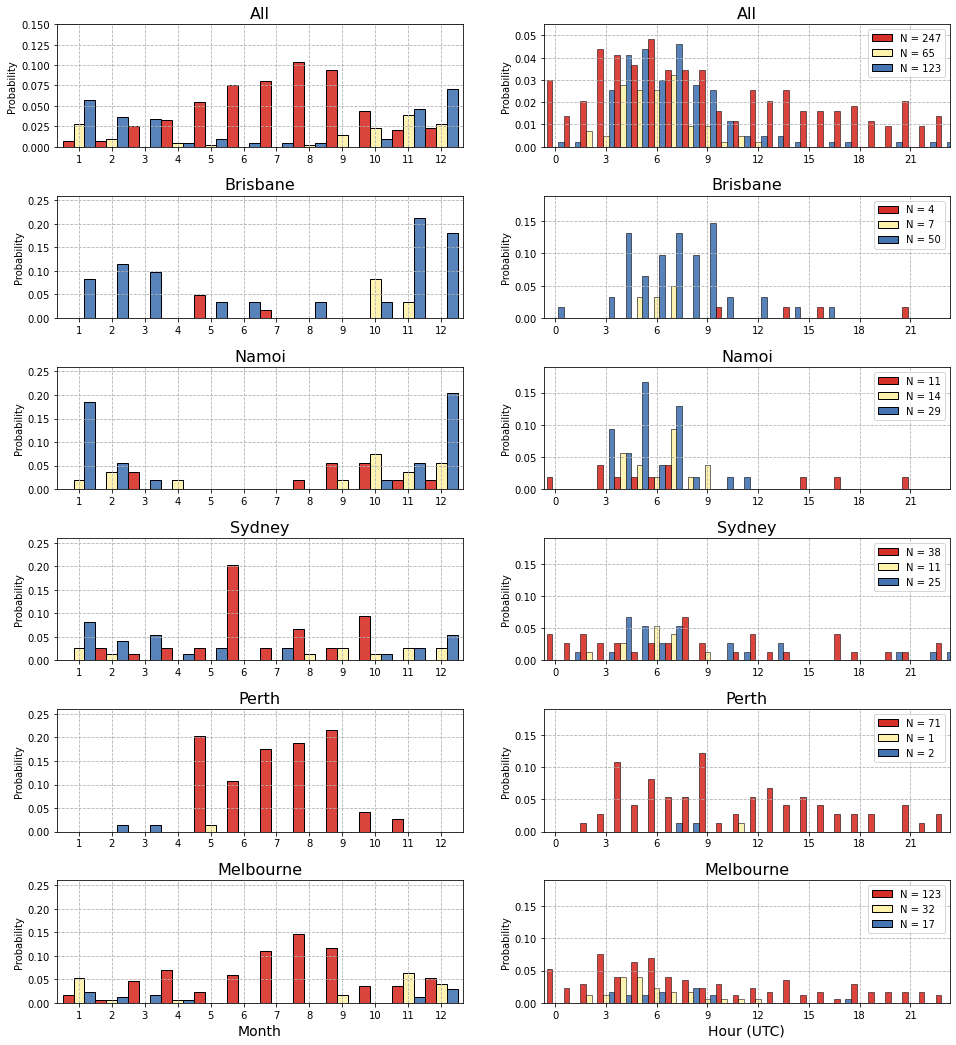

In [17]:
def create_legend(ax,p,labels):
    
    #create legend
    handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in p]
    plt.legend(handles, labels)

def plot_hists(data, title, ax1, ax2, ymax1, ymax2, kde=False):
    
    p = [plt.get_cmap("RdYlBu")(i) for i in [0.1,0.46,0.9]]
    
    sns.histplot(x="month",data=data,discrete=True,hue="cluster_new",multiple="dodge",palette=p, ax=ax1, legend=False, stat="probability", kde=kde, alpha=0.9,
                line_kws={"lw":3})
    ax1.set_title(title,size=16)
    ax1.grid(ls="--")
    ax1.set_ylim([0,ymax1])
    ax1.set_xticks(np.arange(1,13))
    ax1.set_xlim([0.33,12.66])
    ax1.set_xlabel("")
    create_legend(ax1, p, ["N = "+str((data.cluster_new==i).sum()) for i in np.arange(3)])
    
    sns.histplot(x="hour",data=data,discrete=True,hue="cluster_new",multiple="dodge",palette=p, ax=ax2, legend=False, stat="probability", kde=kde, alpha=0.9,
                line_kws={"lw":3})
    ax2.set_title(title,size=16)
    ax2.grid(ls="--")
    ax2.set_ylim([0,ymax2])    
    ax2.set_xlabel("")
    ax2.set_xticks(np.arange(0,24,3))
    ax2.set_xlim([-0.66,23.33])
    create_legend(ax1, p, ["N = "+str((data.cluster_new==i).sum()) for i in np.arange(3)])
    

plt.figure(figsize=[16,18])

rows=6; cols=2

ax1 = plt.subplot(rows,cols,1); ax2 = plt.subplot(rows,cols,2)
plot_hists(pd.concat([melb, syd, bris, perth, namoi], axis=0), "All", ax1, ax2, 0.15, 0.055, kde=False)

ax1 = plt.subplot(rows,cols,3); ax2 = plt.subplot(rows,cols,4)
plot_hists(bris, "Brisbane", ax1, ax2, 0.26, .19)

ax1 = plt.subplot(rows,cols,5); ax2 = plt.subplot(rows,cols,6)
plot_hists(namoi, "Namoi", ax1, ax2, 0.26, .19)

ax1 = plt.subplot(rows,cols,7); ax2 = plt.subplot(rows,cols,8)
plot_hists(syd, "Sydney", ax1, ax2, 0.26, .19)

ax1 = plt.subplot(rows,cols,9); ax2 = plt.subplot(rows,cols,10)
plot_hists(perth, "Perth", ax1, ax2, 0.26, .19)

ax1 = plt.subplot(rows,cols,11); ax2 = plt.subplot(rows,cols,12)
plot_hists(melb, "Melbourne", ax1, ax2, 0.26, .19)

ax1.set_xlabel("Month", size=14); ax2.set_xlabel("Hour (UTC)", size=14)
plt.subplots_adjust(hspace=0.4)

plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/scws_cluster_temporal_hist.jpeg",dpi=1000,bbox_inches="tight")

In [21]:
data=pd.concat([melb, syd, bris, perth, namoi], axis=0).dropna(subset=["azi_shear"])

#Linear
data.loc[(data.aspect_ratio>=3) & (data.major_axis_length>=100),"class2"] = "Linear"
#Non-linear
data.loc[(data.aspect_ratio<3) & (data.major_axis_length>=100),"class2"] = "Non-linear"
#Cellular
data.loc[(data.local_max == 1),"class2"] = "Cellular"
#Macroburst
data.loc[(data.local_max>=2) & (data.major_axis_length<100),"class2"] = "Cell cluster"
#Supercell
data.loc[(data.azi_shear>4.5) & ((data.aspect_ratio<3) | (data.major_axis_length<100)),"class2"] = "Supercellular"
#Shallow
data.loc[(data.max_alt<8) & (data.conv_pct<.4),"class2"] = "Shallow"

data=data.sort_values("class2")

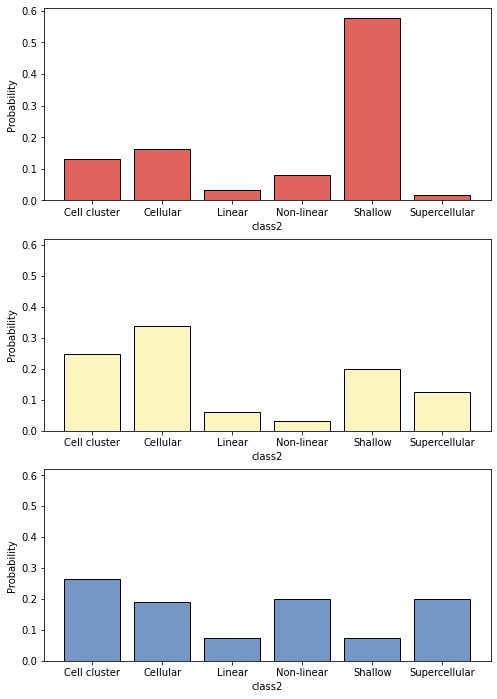

In [23]:
plt.figure(figsize=[8,12])
p = [plt.get_cmap("RdYlBu")(i) for i in [0.1,0.46,0.9]]

plt.subplot(3,1,1)
sns.histplot(x="class2",data=data.query("cluster_new==0"),discrete=True,multiple="dodge",palette=p,shrink=0.8, stat="probability",color=p[0])
plt.subplot(3,1,2)
sns.histplot(x="class2",data=data.query("cluster_new==1"),discrete=True,multiple="dodge",palette=p,shrink=0.8, stat="probability",color=p[1])
plt.ylim([0,0.62])
plt.subplot(3,1,3)
sns.histplot(x="class2",data=data.query("cluster_new==2"),discrete=True,multiple="dodge",palette=p,shrink=0.8, stat="probability",color=p[2])
plt.ylim([0,0.62])

plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/scws_cluster_modes.jpeg",dpi=1000,bbox_inches="tight")

In [9]:
print("MELB:\n",melb.stn_id.value_counts())
print("SYD:\n",syd.stn_id.value_counts())
print("BRIS:\n",bris.stn_id.value_counts())
print("NAMOI:\n",namoi.stn_id.value_counts())
print("PERTH:\n",perth.stn_id.value_counts())

MELB:
 90035    53
86220    29
87166    16
87113    16
88162     8
89002     5
86396     5
86398     5
86371     5
87031     4
86372     4
86282     4
86373     3
87168     2
86038     2
86068     2
86383     2
87184     2
87163     1
86397     1
86361     1
86077     1
88166     1
Name: stn_id, dtype: int64
SYD:
 66208    23
61366    11
68228     8
66043     8
66022     6
66197     5
66137     2
66037     2
67108     2
67113     1
66059     1
66051     1
67119     1
68253     1
68192     1
67105     1
Name: stn_id, dtype: int64
BRIS:
 40043    18
40926    11
40004     7
40927     6
40842     4
40958     3
40211     3
40717     2
40764     2
40082     2
40925     2
40983     1
Name: stn_id, dtype: int64
NAMOI:
 61392    21
55325    13
55202     8
54038     7
64017     5
Name: stn_id, dtype: int64
PERTH:
 9214    21
9215    11
9240    11
9977    10
9021     6
9265     3
9053     3
9172     3
9538     2
9255     2
9256     1
9193     1
Name: stn_id, dtype: int64


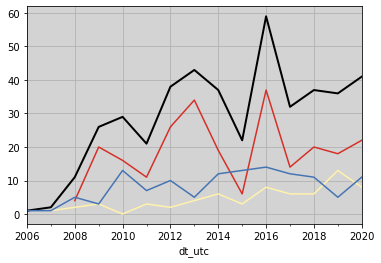

In [46]:
pd.concat([melb, syd, bris, perth, namoi], axis=0).resample("1Y").nunique().group_id.plot(color="k",lw=2)
pd.concat([melb, syd, bris, perth, namoi], axis=0).query("cluster==0").resample("1Y").nunique().group_id.plot(color=p[0])
pd.concat([melb, syd, bris, perth, namoi], axis=0).query("cluster==2").resample("1Y").nunique().group_id.plot(color=p[1])
pd.concat([melb, syd, bris, perth, namoi], axis=0).query("cluster==1").resample("1Y").nunique().group_id.plot(color=p[2])
plt.gca().set_facecolor("lightgray")
plt.gca().grid()